# Model Loading and Inference for Missing Wealth

This code **reconstructs** a previously trained model from the CSV logs and a saved checkpoint (`.pth`), then **fills missing wealth values** in a GeoDataFrame.

- **`load_model_from_csv_and_checkpoint`**:
  1. Reads a log CSV to find the row with the specified `model_name`.  
  2. Parses stored hyperparameters (`backbone`, `mlp_layers`, `dropout`, etc.) and channels used.  
  3. Rebuilds a matching CNN architecture (same number of input channels, same MLP head).  
  4. Loads the `.pth` checkpoint for that model.  

- **`predict_missing_wealth_auto`**:
  1. Loads the specified model from the CSV (or does nothing if `model_name` is `None`).  
  2. Reads a GPKG with missing `weighted_wealth` values, identifies those rows, and **predicts** new wealth indices using the model.  
  3. Updates the GeoDataFrame in place, marking which rows were predicted (`predicted_flag=True`).

In [1]:
import pandas as pd
import ast
import os
import torch
import numpy as np
import geopandas as gpd
from torch import nn
from torchvision.models import (ResNet18_Weights, ResNet50_Weights, 
                                EfficientNet_B0_Weights, 
                                ConvNeXt_Tiny_Weights, 
                                resnet18, resnet50, 
                                efficientnet_b0, convnext_tiny)
from tqdm import tqdm
import torchvision.transforms as T

# Make sure the channel ranges are exactly as in training.
CHANNEL_RANGES = {
    "sentinel_rgb":       (0, 255),    # 3 sub-channels: R, G, B
    "sentinel_ndvi":      (0, 255),
    "sentinel_built_up":  (0, 255),
    "sentinel_nir":       (0, 65535),
    "sentinel_swir1":     (0, 65535),
    "sentinel_swir2":     (0, 65535),
    "viirs_nightlights":  (0, 65535),
    "viirs_gradient":     (0, 65535),
}

def scale_channels(data, channels_to_use):
    """
    Scales each channel in the NPZ file to [0, 1] using CHANNEL_RANGES.
    """
    arrays = []
    for ch in channels_to_use:
        arr = data[ch]
        if arr.ndim == 2:
            arr = arr[..., None]
        ch_min, ch_max = CHANNEL_RANGES[ch]
        arr = (arr - ch_min) / (ch_max - ch_min + 1e-8)
        arrays.append(arr.astype(np.float32))
    combined = np.concatenate(arrays, axis=-1)
    return combined

def load_model_from_csv_and_checkpoint(
    model_name,
    results_csv,
    base_model_dir="data/Results/Models",
    device=None,
    freeze_cnn=False   # If True, freeze the backbone.
):
    """
    Loads a model by reading its hyperparameters from `results_csv` (matching model_name),
    reconstructs the backbone+MLP (with proper weight initialization), and loads its .pth file.
    
    Returns (model, channels_to_use).
    """
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() 
                              else "cuda" if torch.cuda.is_available() 
                              else "cpu")
        print(f"Using device: {device}")
    
    df = pd.read_csv(results_csv)
    match_df = df[df['model_name'] == model_name]
    if len(match_df) == 0:
        raise ValueError(f"No entry found for model_name='{model_name}' in CSV: {results_csv}")
    row = match_df.iloc[-1]
    
    def parse_bool(val):
        return bool(val) if isinstance(val, int) else (str(val).lower()=='true')
    
    backbone = row['backbone']
    pretrained = parse_bool(row['pretrained'])
    dropout = float(row['dropout'])
    mlp_layers = ast.literal_eval(row['mlp_layers'])
    channels_str = ast.literal_eval(row['channels_to_use'])
    
    num_in_channels = sum((3 if c == "sentinel_rgb" else 1) for c in channels_str)
    
    class FlexibleRegressor(nn.Module):
        def __init__(self, num_in_channels, backbone='resnet18', pretrained=True, mlp_layers=[256], dropout=0.2, freeze_cnn=False):
            super().__init__()
            if backbone == 'resnet18':
                if pretrained:
                    self.backbone = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
                else:
                    self.backbone = resnet18(weights=None)
                num_features = 512
            elif backbone == 'resnet50':
                if pretrained:
                    self.backbone = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
                else:
                    self.backbone = resnet50(weights=None)
                num_features = 2048
            elif backbone == 'efficientnet_b0':
                if pretrained:
                    self.backbone = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
                else:
                    self.backbone = efficientnet_b0(weights=None)
                num_features = 1280
            elif backbone == 'convnext_tiny':
                if pretrained:
                    self.backbone = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
                else:
                    self.backbone = convnext_tiny(weights=None)
                num_features = 768
            else:
                raise ValueError(f"Unsupported backbone: {backbone}")
            
            self._replace_first_conv(num_in_channels, backbone)
            
            if backbone.startswith('resnet'):
                self.backbone.fc = nn.Identity()
            elif backbone == 'efficientnet_b0':
                self.backbone.classifier = nn.Identity()
            elif backbone == 'convnext_tiny':
                self.backbone.classifier[2] = nn.Identity()
            
            mlp = []
            prev_dim = num_features
            for hidden_dim in mlp_layers:
                linear_layer = nn.Linear(prev_dim, hidden_dim)
                nn.init.xavier_uniform_(linear_layer.weight)
                if linear_layer.bias is not None:
                    nn.init.constant_(linear_layer.bias, 0)
                mlp.append(linear_layer)
                mlp.append(nn.ReLU())
                if dropout > 0:
                    mlp.append(nn.Dropout(dropout))
                prev_dim = hidden_dim
            final_linear = nn.Linear(prev_dim, 1)
            nn.init.xavier_uniform_(final_linear.weight, gain=0.1)
            if final_linear.bias is not None:
                nn.init.constant_(final_linear.bias, 0)
            mlp.append(final_linear)
            mlp.append(nn.Sigmoid())
            self.mlp = nn.Sequential(*mlp)
            
            if freeze_cnn:
                for param in self.backbone.parameters():
                    param.requires_grad = False
        
        def _replace_first_conv(self, num_in_channels, backbone):
            if backbone in ['resnet18', 'resnet50']:
                old_conv = self.backbone.conv1
                old_weights = old_conv.weight.data
                new_conv = nn.Conv2d(
                    in_channels=num_in_channels,
                    out_channels=old_conv.out_channels,
                    kernel_size=old_conv.kernel_size,
                    stride=old_conv.stride,
                    padding=old_conv.padding,
                    bias=False
                )
                copy_ch = min(3, num_in_channels)
                new_conv.weight.data[:, :copy_ch, :, :] = old_weights[:, :copy_ch, :, :]
                if num_in_channels > 3:
                    nn.init.xavier_normal_(new_conv.weight.data[:, 3:, :, :])
                self.backbone.conv1 = new_conv
            elif backbone == 'efficientnet_b0':
                old_conv = self.backbone.features[0][0]
                old_weights = old_conv.weight.data
                new_conv = nn.Conv2d(
                    in_channels=num_in_channels,
                    out_channels=old_conv.out_channels,
                    kernel_size=old_conv.kernel_size,
                    stride=old_conv.stride,
                    padding=old_conv.padding,
                    bias=False
                )
                copy_ch = min(3, num_in_channels)
                new_conv.weight.data[:, :copy_ch, :, :] = old_weights[:, :copy_ch, :, :]
                if num_in_channels > 3:
                    nn.init.xavier_normal_(new_conv.weight.data[:, 3:, :, :])
                self.backbone.features[0][0] = new_conv
            elif backbone == 'convnext_tiny':
                old_conv = self.backbone.features[0][0]
                old_weights = old_conv.weight.data
                new_conv = nn.Conv2d(
                    in_channels=num_in_channels,
                    out_channels=old_conv.out_channels,
                    kernel_size=old_conv.kernel_size,
                    stride=old_conv.stride,
                    padding=old_conv.padding,
                    bias=False
                )
                copy_ch = min(3, num_in_channels)
                new_conv.weight.data[:, :copy_ch, :, :] = old_weights[:, :copy_ch, :, :]
                if num_in_channels > 3:
                    nn.init.xavier_normal_(new_conv.weight.data[:, 3:, :, :])
                self.backbone.features[0][0] = new_conv
            else:
                raise ValueError(f"Unhandled backbone: {backbone}")
        
        def forward(self, x):
            features = self.backbone(x)
            return self.mlp(features)
    
    model = FlexibleRegressor(
        num_in_channels=num_in_channels,
        backbone=backbone,
        pretrained=pretrained,
        mlp_layers=mlp_layers,
        dropout=dropout,
        freeze_cnn=freeze_cnn
    ).to(device)
    
    checkpoint_path = os.path.join(base_model_dir, f"{model_name}.pth")
    if not os.path.isfile(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint not found: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    
    print(f"Loaded model '{model_name}': {backbone}, pretrained={pretrained}, mlp={mlp_layers}, dropout={dropout}, freeze_cnn={freeze_cnn}")
    return model, channels_str

def predict_missing_wealth_auto(
    gpkg_path,
    country,
    year,
    model_name,
    results_csv,
    base_model_dir="data/Results/Models",
    transform=None,
    device=None,
    freeze_cnn=False
):
    """
    Uses a loaded model (by name) to fill missing 'weighted_wealth' in a GPKG.
    """
    if model_name is None:
        print("No model_name provided; skipping predictions.")
        gdf = gpd.read_file(gpkg_path)
        gdf['predicted_flag'] = False
        return gdf
    
    model, channels_to_use = load_model_from_csv_and_checkpoint(
        model_name=model_name,
        results_csv=results_csv,
        base_model_dir=base_model_dir,
        device=device,
        freeze_cnn=freeze_cnn
    )
    
    if device is None:
        device = torch.device("mps" if torch.backends.mps.is_available() 
                              else "cuda" if torch.cuda.is_available() 
                              else "cpu")
        print(f"Using device: {device}")
    
    gdf = gpd.read_file(gpkg_path)
    # Optionally limit number of rows for testing:
    # gdf = gdf.head(1000)
    gdf['predicted_flag'] = False
    missing_mask = gdf['weighted_wealth'].isna()
    missing_indices = gdf.index[missing_mask]
    print(f"Found {len(missing_indices)} rows with NaN in weighted_wealth. Predicting...")
    
    for idx in tqdm(missing_indices):
        cell_id = gdf.at[idx, 'cell_id']
        npz_path = f"data/Results/SatelliteImageData/Images/Combined/{country}/{year}/cell_{cell_id}/combined_data.npz"
        if not os.path.isfile(npz_path):
            continue
        
        data = np.load(npz_path)
        # Apply the same per-channel scaling as in training.
        combined = scale_channels(data, channels_to_use)
        
        # Apply transform if provided; otherwise convert to tensor and permute to [C,H,W].
        if transform:
            combined_tensor = transform(combined)
        else:
            combined_tensor = torch.from_numpy(combined).permute(2, 0, 1)
        
        combined_tensor = combined_tensor.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(combined_tensor).item()
        
        gdf.at[idx, 'weighted_wealth'] = pred
        gdf.at[idx, 'predicted_flag'] = True
    
    print("Prediction complete. Missing wealth values have been filled.")
    return gdf

class ToTensor:
    """Converts a (H, W, C) numpy array to a torch.FloatTensor of shape (C, H, W)."""
    def __call__(self, sample):
        return torch.from_numpy(sample).permute(2, 0, 1)

transform = T.Compose([
#    RandomFlipAndRotate(p=0.5),
    ToTensor()
])

In [2]:
csv_path = "data/Results/Models/TrainingResultsLog.csv"  # CSV with training log and hyperparameters

country = 'Senegal'
year = '2019'
wealth_index_file = f"data/Results/LabelledGrids/{country}_{year}_wealthindex_labelled.gpkg"

model_name = "final_model"  # The name of the model checkpoint to load

updated_gdf = predict_missing_wealth_auto(
    gpkg_path=wealth_index_file,
    country=country,
    year=year,
    model_name=model_name,
    results_csv=csv_path,
    base_model_dir="data/Results/Models",
    transform=transform,  # Replace with your defined transform (if any)
    freeze_cnn=True       # Set according to your desired configuration
)

Using device: mps
Loaded model 'final_model': efficientnet_b0, pretrained=True, mlp=[64, 32], dropout=0.05, freeze_cnn=True
Using device: mps
Found 7405 rows with NaN in weighted_wealth. Predicting...


100%|██████████| 7405/7405 [02:12<00:00, 55.94it/s]

Prediction complete. Missing wealth values have been filled.


In [3]:
# drop all rows that have predicted_flag = False (only show the ones that were predicted)
updated_gdf = updated_gdf[updated_gdf['predicted_flag'] == True]
# sort bei weighted_wealth
updated_gdf.sort_values(by='weighted_wealth', inplace=True)
updated_gdf.reset_index(drop=True, inplace=True)

updated_gdf

,cell_id,total_area,covered_area,coverage_percent,weighted_wealth,geometry,predicted_flag
0,4614,25000000.0,0.000000e+00,0.000000,0.170889,"POLYGON ((591184.389 1762011.981, 591184.389 1...",True
1,4374,25000000.0,0.000000e+00,0.000000,0.189911,"POLYGON ((576184.389 1757011.981, 576184.389 1...",True
2,4455,25000000.0,0.000000e+00,0.000000,0.190221,"POLYGON ((581184.389 1757011.981, 581184.389 1...",True
3,4692,25000000.0,0.000000e+00,0.000000,0.196921,"POLYGON ((596184.389 1767011.981, 596184.389 1...",True
4,3311,25000000.0,0.000000e+00,0.000000,0.197974,"POLYGON ((511184.389 1757011.981, 511184.389 1...",True
...,...,...,...,...,...,...,...
7400,2976,25000000.0,4.018856e+06,16.075425,0.650311,"POLYGON ((491184.389 1702011.981, 491184.389 1...",True
7401,634,25000000.0,1.937679e+06,7.750718,0.650449,"POLYGON ((346184.389 1772011.981, 346184.389 1...",True
7402,90,25000000.0,5.380275e+06,21.521098,0.653877,"POLYGON ((296184.389 1637011.981, 296184.389 1...",True
7403,5,25000000.0,7.915282e+06,31.661126,0.660394,"POLYGON ((251184.389 1627011.981, 251184.389 1...",True


In [ ]:
# Build a new list of file paths (some might be newly predicted):
satellite_images_filepaths = []
for cell_id in updated_gdf['cell_id']:
    path = f"data/Results/SatelliteImageData/Images/Combined/{country}/{year}/cell_{cell_id}/combined_data.npz"
    satellite_images_filepaths.append(path)

# The rest is the same as your original code
import matplotlib.pyplot as plt
import numpy as np

def plot_satellite_data(index, filepaths, gdf):
    npz_file_path = filepaths[index]
    cell_id = gdf['cell_id'][index]
    wealth_index = gdf['weighted_wealth'][index]

    data = np.load(npz_file_path)
    
    fig, axs = plt.subplots(1, 8, figsize=(20, 3))
    fig.suptitle(f'Cell {cell_id} - Wealth Index: {wealth_index}', fontsize=16)
    
    plots = [
        ('sentinel_rgb', 'RGB', None),
        ('sentinel_ndvi', 'NDVI', 'RdYlGn'),
        ('sentinel_built_up', 'Built-up', 'gray'),
        ('sentinel_nir', 'NIR', 'inferno'),
        ('sentinel_swir1', 'SWIR1', 'inferno'),
        ('sentinel_swir2', 'SWIR2', 'inferno'),
        ('viirs_nightlights', 'Nightlights', 'viridis'),
        ('viirs_gradient', 'Gradient', 'viridis')
    ]
    
    for ax, (key, title, cmap) in zip(axs, plots):
        im = ax.imshow(data[key], cmap=cmap)
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Interactive slider
import ipywidgets as widgets
from ipywidgets import interact

@interact(index=widgets.IntSlider(min=0, max=len(satellite_images_filepaths)-1, step=1, value=0))
def plot_satellite_data_widget(index=0):
    plot_satellite_data(index, satellite_images_filepaths, updated_gdf)

interactive(children=(IntSlider(value=0, description='index', max=7404), Output()), _dom_classes=('widget-inte…

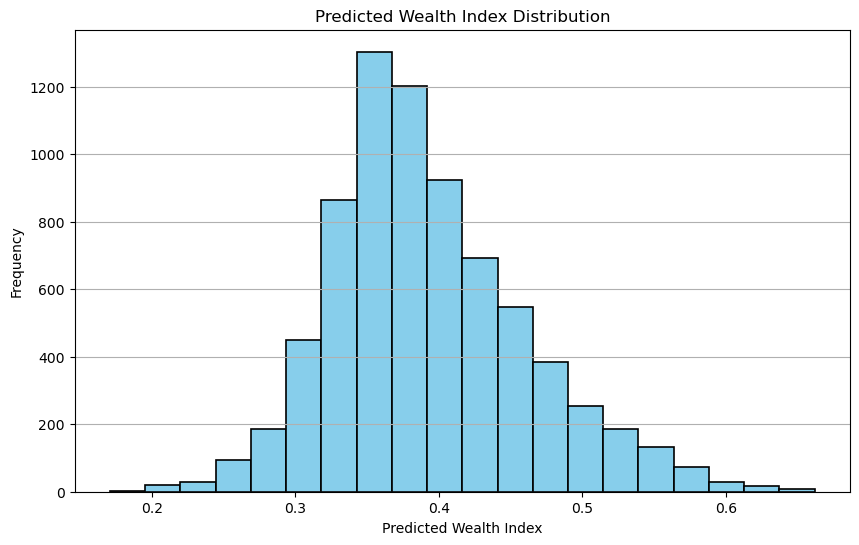

In [5]:
# plot histogam of the predicted wealth index
plt.figure(figsize=(10, 6))
plt.hist(updated_gdf['weighted_wealth'], bins=20, color='skyblue', edgecolor='black', linewidth=1.2)
plt.title("Predicted Wealth Index Distribution")
plt.xlabel("Predicted Wealth Index")
plt.ylabel("Frequency")
plt.grid(axis='y')
plt.show()


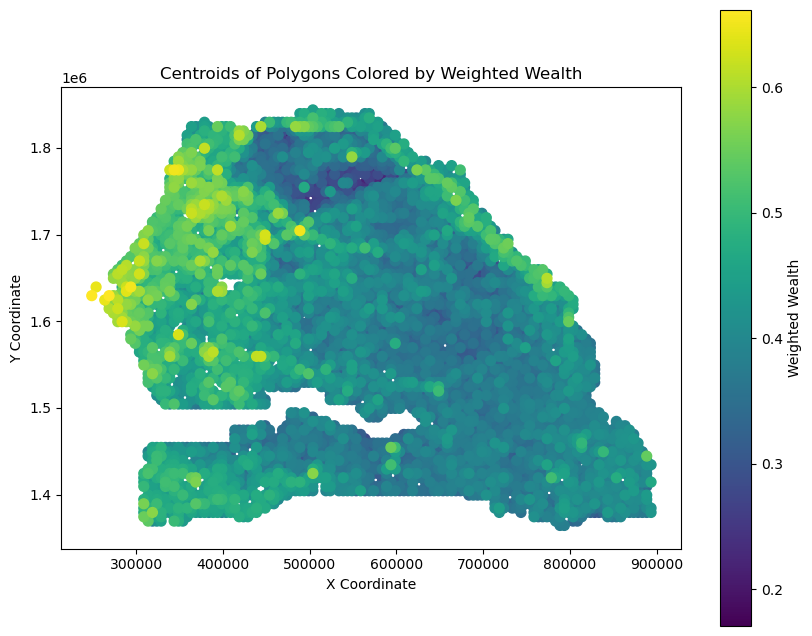

In [6]:
import matplotlib.pyplot as plt
import geopandas as gpd

# Calculate centroids for each polygon and add them as a new column
updated_gdf['centroid'] = updated_gdf.geometry.centroid

# Extract centroid coordinates for plotting
updated_gdf['centroid_x'] = updated_gdf.centroid.x
updated_gdf['centroid_y'] = updated_gdf.centroid.y

# Create a plot with the polygons and overlay the centroids colored by weighted wealth
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the base polygons for context (optional)
updated_gdf.plot(ax=ax, color='lightgrey', edgecolor='black')

# Scatter plot for centroids, colored by weighted wealth
scatter = ax.scatter(updated_gdf['centroid_x'], updated_gdf['centroid_y'], 
                     c=updated_gdf['weighted_wealth'], cmap='viridis', s=50)

# Add a colorbar to indicate weighted wealth values
cbar = fig.colorbar(scatter, ax=ax, label='Weighted Wealth')

ax.set_title("Centroids of Polygons Colored by Weighted Wealth")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
plt.show()